# 삼성전자 주가 데이터 다운로드
- Yahoo Finance 에서 주가 데이터 다운로드 (https://finance.yahoo.com/)
    - 검색 키워드 '005930.KS' 입력
- 검색 후 Historical Data 선택

![yahoo finance](figures/rnn/21_yahoo_stock1.png)

- `Start Date: 2000년 1월 4일 End Date: 오늘날짜` 선택
- Apply 클릭 후 다운로드
![yahoo finance](figures/rnn/22_yahoo_stock2.png)

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchinfo

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split  

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
#data loading + EDA

df = pd.read_csv("datasets/005930.KS.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5977 entries, 0 to 5976
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5977 non-null   object 
 1   Open       5977 non-null   float64
 2   High       5977 non-null   float64
 3   Low        5977 non-null   float64
 4   Close      5977 non-null   float64
 5   Adj Close  5977 non-null   float64
 6   Volume     5977 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 327.0+ KB


In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4514.582031,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4122.971680,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4152.528320,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4093.417480,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4263.360352,46880000


In [16]:
#Date => datetime 타입으로 변경 -> index 변환.
## 시계열 데이터는 (행) index로 일시를 가지도록 구성.

#이렇게 바꾸는 것에 익숙해 져야 한다!
df['Date']=pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)


In [17]:
#결측치 확인

df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

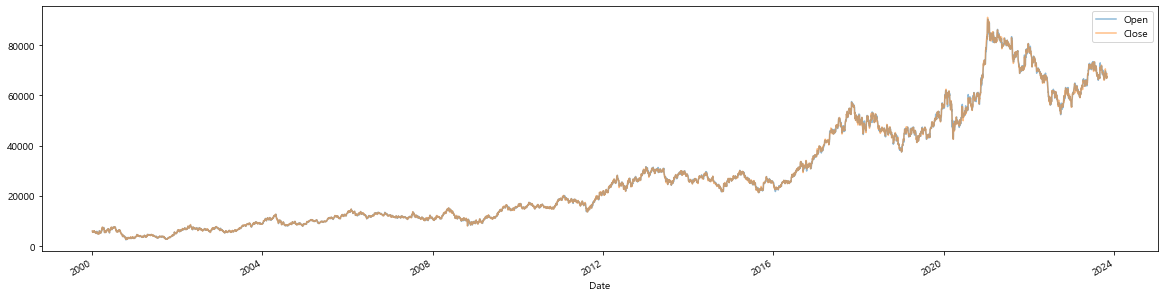

In [18]:
## 시가, 종가의 흐름을 선그래프로 보기


#두 개의 선을 한 그래프에 같이 그리는 코드.
#alpha는 투명도를 정하는 것이다. 투명도를 정해서, 비슷비슷한 놈들을 더 잘 보이게 하자.


df[['Open','Close']].plot(figsize=(20,5),alpha=0.5);

<AxesSubplot:xlabel='Date'>

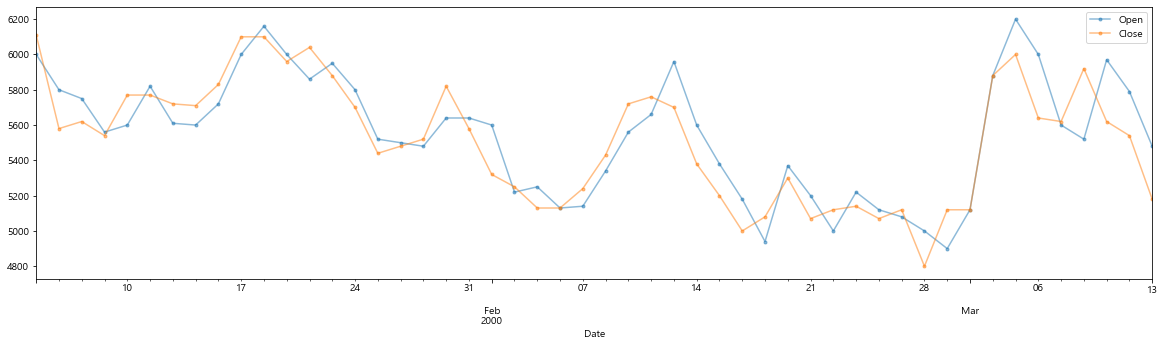

In [19]:
#약간 다르게 해볼까?

df[['Open','Close']][0:50].plot(figsize=(20,5),alpha=0.5,marker='.')

###  Sequential Data  구성
- X: 50일치 데이터(ex:1일 ~ 50일), y: 51일째 주가. (ex: 51일)
    - 50일의 연속된 주식데이터를 학습하여 51일째 주가를 예측한다.
    - X의 한개의 데이터가 50일치 주가데이터가 된다.

![img](figures/rnn/20_stock_dataset.png)

[연속된 날짜가 5인 경우]

# X와 Y를 만들기

- X (input) feature 구성: Open,High,Low,Close,Adj Close, Volumn
- y (output): Close


In [22]:
y= df['Close'].to_frame() #(총 데이터수,1)
X = df

X.shape, y.shape

((5977, 6), (5977, 1))

In [23]:
X.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4514.582031,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,4122.971680,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,4152.528320,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,4093.417480,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,4263.360352,46880000


## 전처리

In [24]:
#전처리는 feature 간의 scaling을 맞추는 작업이다.
#한마디로 정규분포와 비스무레하게 데이터를 맞추는 것이다.

#X : Standard Scaling (평균:0, 표준편차:1)
#y : MinMax Scaling (최소:0, 최대:1) => X의 scale과 비슷한 값으로 변환한다.



In [28]:
#연속된 날짜가 5인 경우

timestep = 50 #seq length

data_X = [] #데이터를 모을 리스트. x:(50,6)
data_y = [] #y값을 모을 리스트


#데이터를 처리해준다.
for i in range(0,y.size - timestep): 
    #총 개수 - seq_length: 이 이후 반복시에는 남은 데이터가 51개가 안되어서 데이터 구성이 안된다.
    # X: 0~50,y:50 (1씩 증가)
    _X = X[i:i+timestep]
    _y = y[i:i+timestep]
    data_X.append(_X)
    data_y.append(_y)
    

In [30]:
np.set_printoptions(linewidth=np.inf) #한줄에 n개 원소를 출력한다.

In [31]:
#데이터 직접 확인.

data_X[0]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4514.582031,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,4122.971680,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,4152.528320,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,4093.417480,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,4263.360352,46880000
2000-01-11,5820.0,6100.0,5770.0,5770.0,4263.360352,59745000
2000-01-12,5610.0,5740.0,5600.0,5720.0,4226.416016,29220000
2000-01-13,5600.0,5740.0,5560.0,5710.0,4219.027832,41190000
2000-01-14,5720.0,5880.0,5680.0,5830.0,4307.693359,49375000


### Train / test set 분리

In [32]:
#일단 데이터들을 나눈다.


#test_size를 통해 데이터들의 비율을 나눈다.
#data_X,data_y의 데이터를 잘 섞도록 한다.
X_train, X_test, y_train, y_test = train_test_split(data_X,data_y,test_size=0.2)


#정보를 보도록 하자.
np.shape(X_train), np.shape(X_test)



((4741, 50, 6), (1186, 50, 6))

### Dataset, DataLoader 구성

In [45]:
#Tensor 변환:
## X_train:List -> ndarray -> torch.Tensor
X_train_tensor = torch.tensor(np.array(X_train),dtype=torch.float32)
X_test_tensor = torch.tensor(np.array(X_test),dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train),dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test),dtype=torch.float32)

In [46]:
# Dataset 생성 -> raw 데이터 : 메모리상의 Tensor ===>TensorDataset

trainset = TensorDataset(X_train_tensor,y_train_tensor)
testset = TensorDataset(X_test_tensor,y_test_tensor)

print("데이터 개수:",len(trainset),len(testset))

데이터 개수: 4741 1186


In [47]:
#DataLoader 생성

trainloader = DataLoader(trainset,batch_size=200,shuffle=True,drop_last=True)
testloader = DataLoader(testset,batch_size=200)


print("에폭당 step수:",len(trainloader),len(testloader))

에폭당 step수: 23 6


In [48]:
#LSTM layer  생성 후 추론

a,b = next(iter(trainloader))
a.shape, b.shape

(torch.Size([200, 50, 6]), torch.Size([200, 50, 1]))

In [49]:
lstm = nn.LSTM(input_size=6,hidden_size=10,
               #batch_first=True) #(batch,seq,feature)

              )
a = a.permute(1,0,2) #데이터의 배치를 바꾼다.
o,(h,c) = lstm(a.type(torch.float32))

o.shape,h.shape,c.shape



(torch.Size([50, 200, 10]), torch.Size([1, 200, 10]), torch.Size([1, 200, 10]))

### 모델 정의

In [64]:
class StockLSTM(nn.Module):
    def __init__(self,input_size:"feature수",
                 hidden_size:"hidden(유닛)수",
                num_layers:"레이어개수"=1,
                bidirectional:"양방향여부"=False):
        
        super().__init__()
        
        
        
        self.lstm = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional)
        D = 2 if bidirectional else 1 #bidirectional여부에 따라 값을 다르게 한다.
        self.output = nn.Linear(in_features=D*num_layers*hidden_size,
                               out_features=1) #출력
        
    def forward(self,X):
        #LSTM(특성을 추출) -- hidden state -->Linear -> 예측결과
        # X:(batch,seq,feature) -> (seq,batch,feature)
        X = X.permute(1,0,2)
        out, (hidden_state,cell_state) = self.lstm(X) #hidden state 값을 쓴다.
        # hidden state (seq,batch,hidden)
        
        hidden_state = hidden_state.permute(1,0,2)
        nn.Flatten()(hidden_state) 
        pred = self.output(hidden_state) #lstm은 hidden을 뽑아서 output에 전달해준다.
       # nn.Sigmoid()(pred) #값을 0부터 1사이로 정규화해준다.
        return pred #pred 값을 전달한다.
        
    
    

In [65]:
#본격적으로 모델을 정의한다.

model = StockLSTM(input_size=6,hidden_size=50)


### train

In [66]:
#하이퍼파라미터

N_EPOCH = 1000
LR=0.0001

INPUT_SIZE=6
HIDDEN_SIZE=30
NUM_LAYERS=1
BIDIRECTIONAL = False


In [67]:
model = StockLSTM(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,BIDIRECTIONAL)


model = model.to(device) #device로 이동을 잘 시켜야 딥러닝을 수행할 수 있다.


#loss_fn = 회귀: MSE

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LR)


In [72]:
#코드가 살짝 잘못되었다. 그러니 소스코드를 보도록 하자.


train_loss_list = []
valid_loss_list = []

for epoch in range(N_EPOCH):
    
    model.train()
    train_loss = 0.0
    for X,y in trainloader:
        #1. device로 이동한다.
        X,y = X.to(device),y.to(device)
        #2. 추정
        pred = model(X)
        
        #3.Loss 계산
        loss = loss_fn(pred,y)
        #4.grad 계산
        loss.backward()
        
        #5. layer의 파라미터들을 update한다.
        optimizer.step()
        
        #6. gradient 초기화
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(trainloader) #train_loss 평균 계산
    train_loss_list.append(train_loss) #한 epoch에 대한 학습 끝남.
    
    
    ##검증
    model.eval() #eval 모드로 바꿔야 한다.
    valid_loss= 0.0
    for X_valid,y_valid in testloader:
        # 1.device 이동
        X_valid,y_valid = X_valid.to(device), y_valid.to(device)
        
     
        
        with torch.no_grad():
            #2. 추정
            pred_valid = model(X_valid)
            
            #3.loss 계산
            valid_loss += loss_fn(pred_valid,y_valid).item()
            
    valid_loss /= len(testloader) #valid_loss의 평균
    valid_loss_list.append(valid_loss)
    if epoch % 100 == 0 or epoch == (N_EPOCH-1):
        #epoch이 100번 돌았거나 마지막 epoch 이라면
        print(f"[{epoch+1}/{N_EPOCH}] train loss:{train_loss} valid loss:{valid_loss}")
        

[1/1000] train loss:1205280990.6086957 valid loss:1135666730.6666667
[101/1000] train loss:1199501050.4347825 valid loss:1135578880.0


KeyboardInterrupt: 

In [73]:
y_scaler.inverse_transform([[0.0000356]])
#여기서 나오는 값이 바로 예측값의 오차이다.

NameError: name 'y_scaler' is not defined

In [83]:
new_X = torch.tensor(np.expand_dims(data_X[-1],axis=0),dtype=torch.float32) #데이터를 섞기 전이다.
new_X.shape

torch.Size([1, 50, 6])

In [84]:
pred_new = model(new_X.to(device))

In [85]:
pred_new

tensor([[[8.6703]]], grad_fn=<ViewBackward0>)

In [89]:
y_scaler.inverse_transform(pred_new.detach().numpy())

#여기서 출력된 값이 바로 예측값이다.
#결과:xxxx원 정도의 오차가 났다.

NameError: name 'y_scaler' is not defined